<a href="https://colab.research.google.com/github/lukehartfield/TestingAssetPricingModels/blob/main/Finance%20Project%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAS Traders Project 3


In [ ]:
import io, re, zipfile, requests
import pandas as pd
import numpy as np
import scipy.stats as sps

# ------------------------
# Constants & Regex
# ------------------------
DATE_RE = re.compile(r"^\s*(\d{6})\s+")
MIN_PERIOD = pd.Period('1926-07', 'M')
MAX_PERIOD = pd.Period('2025-08', 'M')

_MONTH_ALIASES = {
    'jan':'Jan','feb':'Feb','mar':'Mar','apr':'Apr','may':'May','jun':'Jun',
    'jul':'Jul','aug':'Aug','sep':'Sep','oct':'Oct','nov':'Nov','dec':'Dec'
}

# ------------------------
# Flexible Month Parsing & Helpers
# ------------------------
def parse_month_any(s: str) -> pd.Period:
    s = s.strip()
    m = re.fullmatch(r"(\d{4})-(\d{2})", s)  # YYYY-MM
    if m:
        y, mm = int(m.group(1)), int(m.group(2))
        return pd.Period(freq='M', year=y, month=mm)
    m = re.fullmatch(r"(\d{2})/(\d{4})", s)  # MM/YYYY
    if m:
        mm, y = int(m.group(1)), int(m.group(2))
        return pd.Period(freq='M', year=y, month=mm)
    m = re.fullmatch(r"(\d{4})(\d{2})", s)   # YYYYMM
    if m:
        y, mm = int(m.group(1)), int(m.group(2))
        return pd.Period(freq='M', year=y, month=mm)
    m = re.fullmatch(r"([A-Za-z]{3})-(\d{4})", s)  # Mon-YYYY
    if m:
        mon = _MONTH_ALIASES.get(m.group(1).lower())
        if not mon:
            raise ValueError(f"Unrecognized month token: {m.group(1)}")
        y = int(m.group(2))
        mm = pd.to_datetime(f"01-{mon}-{y}", format="%d-%b-%Y").month
        return pd.Period(freq='M', year=y, month=mm)
    raise ValueError(f"Unrecognized date format: {s}")

def prompt_month(prompt: str) -> pd.Period:
    while True:
        raw = input(prompt).strip()
        try:
            p = parse_month_any(raw)
        except Exception as e:
            print(f"Invalid date. Use YYYY-MM, MM/YYYY, YYYYMM, or Mon-YYYY. ({e})")
            continue
        if p < MIN_PERIOD or p > MAX_PERIOD:
            print(f"Out of bounds. Choose between {MIN_PERIOD.strftime('%b-%Y')} and {MAX_PERIOD.strftime('%b-%Y')}.")
            continue
        return p

def get_user_month_range() -> tuple[pd.Period, pd.Period]:
    while True:
        start_p = prompt_month("Start month: ")
        end_p   = prompt_month("End month:   ")
        if start_p > end_p:
            print("Start month cannot be after end month. Please try again.")
            continue
        return start_p, end_p

def filter_by_month_range(df: pd.DataFrame, start_p: pd.Period, end_p: pd.Period) -> pd.DataFrame:
    if not isinstance(df.index, pd.PeriodIndex) or df.index.freqstr != 'M':
        raise ValueError("DataFrame must be indexed by a monthly PeriodIndex (freq='M').")
    return df.loc[(df.index >= start_p) & (df.index <= end_p)]

def as_month_year_index(df: pd.DataFrame, fmt: str = "%b-%Y") -> pd.DataFrame:
    if not isinstance(df.index, pd.PeriodIndex) or df.index.freqstr != 'M':
        raise ValueError("DataFrame must be indexed by a monthly PeriodIndex (freq='M').")
    out = df.copy()
    out.index = df.index.to_timestamp().strftime(fmt)
    out.index.name = "Month-Year"
    return out

# ------------------------
# Fetch & Parse (Ken French text-in-zip tables)
# ------------------------
def fetch_txt_from_zip(url: str) -> str:
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        name = z.namelist()[0]
        raw = z.read(name)
    return raw.decode("latin-1", errors="ignore")

DATE_RE = re.compile(r"^\s*(\d{6})\s+")

def parse_french_txt_table(txt: str, expected_cols=None, block_header=None) -> pd.DataFrame:
    txt_lines = txt.splitlines()
    start_ix = 0
    header_ix = None

    # 1) Locate the start of the monthly block (first YYYYMM line after optional block header)
    if block_header is not None:
        for i, line in enumerate(txt_lines):
            if block_header.strip() in line:
                header_ix = i
                break
        if header_ix is None:
            raise ValueError(f"Section header '{block_header}' not found in text!")
        for i in range(header_ix + 1, len(txt_lines)):
            if DATE_RE.match(txt_lines[i]):
                start_ix = i
                break
        else:
            raise ValueError(f"No YYYYMM monthly block found after header '{block_header}'")
    else:
        for i, line in enumerate(txt_lines):
            if DATE_RE.match(line):
                start_ix = i
                break
        else:
            raise ValueError("No YYYYMM monthly block found in text!")

    # 2) If expected_cols not given, try to auto-extract the true FF headers
    #    by scanning a few lines above start_ix and regex-matching portfolio labels.
    auto_cols = None
    if expected_cols is None:
        # Concatenate up to the previous 3 lines into one buffer (headers can span lines)
        header_buf_lines = []
        scan_from = max(0, start_ix - 3)
        for j in range(scan_from, start_ix):
            header_buf_lines.append(txt_lines[j])
        header_buf = " ".join(header_buf_lines)

        # Regex that captures the 25 labels:
        #   - SMALL LoBM | SMALL HiBM
        #   - ME1 BM1 .. ME5 BM5
        #   - BIG LoBM | BIG HiBM
        # This finds *multi-word* tokens as single labels.
        import re as _re
        pat = _re.compile(r"(SMALL\s+(?:LoBM|HiBM))|(ME[1-5]\s+BM[1-5])|(BIG\s+(?:LoBM|HiBM))")
        matches = [m.group(0) for m in pat.finditer(header_buf)]

        # The line often also includes the full 25 labels; keep order as found.
        # Remove duplicates while preserving order (rarely needed but safe).
        seen = set()
        ordered = []
        for lab in matches:
            if lab not in seen:
                seen.add(lab)
                ordered.append(lab)

        # Only trust if we got exactly 25 labels
        if len(ordered) == 25:
            auto_cols = ordered

    # 3) Parse the contiguous monthly block (stop at first non-matching line)
    rows = []
    for line in txt_lines[start_ix:]:
        if DATE_RE.match(line):
            parts = line.strip().split()
            yyyymm, *vals = parts
            rows.append([yyyymm] + vals)
        else:
            break

    if not rows:
        raise ValueError("No contiguous monthly YYYYMM block found.")

    # 4) Build DataFrame and set columns
    df = pd.DataFrame(rows)
    df.rename(columns={0: "Date"}, inplace=True)

    # Pick column names priority: user-supplied expected_cols > auto-detected > generic
    if expected_cols is not None:
        df.columns = ["Date"] + expected_cols
    elif auto_cols is not None:
        df.columns = ["Date"] + auto_cols
    else:
        n_cols = df.shape[1] - 1
        df.columns = ["Date"] + [f"Col{i}" for i in range(1, n_cols + 1)]

    # 5) Dates → PeriodIndex (monthly), numeric conversion (percent → decimal)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m", errors="coerce")
    df = df.dropna(subset=["Date"])
    df["Date"] = df["Date"].dt.to_period("M")
    df = df.set_index("Date")

    df = df.apply(pd.to_numeric, errors="coerce") / 100.0
    df = df.dropna(how="all")

    # If duplicates (shouldn't happen for monthly), collapse by month
    if df.index.has_duplicates:
        df = df.groupby(level=0).mean()

    return df


def _ols_column(y: np.ndarray, X: np.ndarray):
    mask = ~np.isnan(y) & ~np.any(np.isnan(X), axis=1)
    y_ = y[mask]
    X_ = X[mask]
    T, k = X_.shape
    if T <= k:
        b = np.full(k, np.nan)
        se = np.full(k, np.nan)
        tstats = np.full(k, np.nan)
        r2 = np.nan
        resid = np.full_like(y, np.nan)
        yhat = np.full_like(y, np.nan)
        return b, se, tstats, r2, resid, yhat
    XtX = X_.T @ X_
    XtX_inv = np.linalg.inv(XtX)
    Xty = X_.T @ y_
    b = XtX_inv @ Xty
    yhat_ = X_ @ b
    e_ = y_ - yhat_
    s2 = (e_.T @ e_) / (T - k)
    var_b = s2 * XtX_inv
    se = np.sqrt(np.diag(var_b))
    tstats = b / se
    sst = ((y_ - y_.mean())**2).sum()
    ssr = (e_**2).sum()
    r2 = 1.0 - ssr/sst if sst > 0 else np.nan
    yhat = np.full_like(y, np.nan)
    resid = np.full_like(y, np.nan)
    yhat[mask] = yhat_
    resid[mask] = e_
    return b, se, tstats, r2, resid, yhat

def run_panel_regressions(Y_df: pd.DataFrame, factors_df: pd.DataFrame, model: str):
    if model == "CAPM":
        facs = ["Mkt-RF"]
    elif model == "FF3":
        facs = ["Mkt-RF", "SMB", "HML"]
    else:
        raise ValueError("model must be 'CAPM' or 'FF3'")
    X = np.column_stack([np.ones(len(factors_df)), factors_df[facs].to_numpy()])
    k = X.shape[1]
    cols = Y_df.columns
    b_mat = np.zeros((len(cols), k))
    se_mat = np.zeros((len(cols), k))
    t_mat = np.zeros((len(cols), k))
    r2_vec = np.zeros(len(cols))
    T_vec = np.zeros(len(cols), dtype=int)
    yhat_df = pd.DataFrame(index=Y_df.index, columns=cols, dtype=float)
    resid_df = pd.DataFrame(index=Y_df.index, columns=cols, dtype=float)
    for j, c in enumerate(cols):
        y = Y_df[c].to_numpy(dtype=float)
        b, se, tstats, r2, resid, yhat = _ols_column(y, X)
        b_mat[j, :] = b
        se_mat[j, :] = se
        t_mat[j, :] = tstats
        r2_vec[j] = r2
        mask = ~np.isnan(y) & ~np.any(np.isnan(X), axis=1)
        T_vec[j] = int(mask.sum())
        yhat_df[c] = yhat
        resid_df[c] = resid
    if model == "CAPM":
        param_cols = ["alpha", "beta_MktRF"]
        se_cols    = ["se_alpha", "se_MktRF"]
        t_cols     = ["t_alpha", "t_MktRF"]
    else:
        param_cols = ["alpha", "beta_MktRF", "beta_SMB", "beta_HML"]
        se_cols    = ["se_alpha", "se_MktRF", "se_SMB", "se_HML"]
        t_cols     = ["t_alpha", "t_MktRF", "t_SMB", "t_HML"]
    params_df = pd.DataFrame(index=cols)
    params_df[param_cols] = b_mat
    params_df[se_cols] = se_mat
    params_df[t_cols] = t_mat
    params_df["R2"] = r2_vec
    params_df["T"] = T_vec
    Sigma_e = resid_df.cov(min_periods=1)
    Sigma_f = factors_df[facs].cov(min_periods=1)
    return params_df, yhat_df, resid_df, Sigma_e, Sigma_f

# --- GRS-F (CAPM & FF3) ---

def grs_test(alpha_vec, Sigma_e, T, N, K, fbar, Sigma_f):
    """
    Returns: dict with F, df1, df2, pval
    """
    alpha  = np.asarray(alpha_vec, float).reshape(-1, 1)  # N×1
    Sigma_e = np.asarray(Sigma_e, float)                  # N×N
    fbar   = np.asarray(fbar, float).reshape(-1, 1)       # K×1
    Sigma_f = np.asarray(Sigma_f, float)                  # K×K

    # Inverses
    Sigma_e_inv = np.linalg.inv(Sigma_e)
    Sigma_f_inv = np.linalg.inv(Sigma_f)

    # GRS pieces
    alpha_quad = (alpha.T @ Sigma_e_inv @ alpha).item()       # α′Σe^{-1}α
    denom      = (1.0 + (fbar.T @ Sigma_f_inv @ fbar).item()) # 1 + f̄′Σf^{-1}f̄
    Fnum       = (T / N) * ((T - N - K) / (T - K - 1))
    Fstat      = Fnum * (alpha_quad / denom)

    df1, df2 = N, (T - N - K)
    pval = 1.0 - sps.f.cdf(Fstat, df1, df2)
    return {"F": float(Fstat), "df1": int(df1), "df2": int(df2), "pval": float(pval)}

def fama_macbeth(Y_df, betas_df, add_intercept=True):
    """
    Y_df: T×N excess returns (index = dates, columns = portfolios)
    betas_df: N×K betas (index = portfolios, columns = factor names)
    Returns: mean lambdas, FM SEs, Shanken-corrected SEs, full lambda_t series
    """
    # Align columns/rows
    Y = Y_df.copy().sort_index()
    betas = betas_df.copy().loc[Y.columns]

    N = betas.shape[0]
    K = betas.shape[1]
    T = Y.shape[0]

    # Design matrix for cross section
    B = betas.values  # N×K
    if add_intercept:
        X = np.column_stack([np.ones(N), B])  # N×(1+K)
        kx = K + 1
        colnames = ['Const'] + list(betas.columns)
    else:
        X = B
        kx = K
        colnames = list(betas.columns)

    # Per-month cross-sectional λ_t by OLS
    XtX_inv = np.linalg.inv(X.T @ X)
    lambdas = []
    for t in Y.index:
        r_t = Y.loc[t].values.reshape(-1, 1)  # N×1
        lam_t = XtX_inv @ (X.T @ r_t)        # kx×1
        lambdas.append(lam_t.ravel())

    lambdas = np.vstack(lambdas)             # T×kx
    lambdas_df = pd.DataFrame(lambdas, index=Y.index, columns=colnames)

    # FM estimates: time-series means of λ_t
    lam_bar = lambdas_df.mean()
    lam_cov = lambdas_df.cov()
    se_fm = np.sqrt(np.diag(lam_cov) / T)
    t_fm = lam_bar.values / se_fm

    # Shanken correction factor
    # Use factor mean/cov from your factor set (match betas' factors)
    # If you included const, exclude it from the correction
    if add_intercept:
        fac_cols = colnames[1:]
        mu_f = factors_df_rng[fac_cols].mean().values.reshape(-1,1)
        Sigma_f = factors_df_rng[fac_cols].cov().values
        inflator = np.sqrt(1.0 + float(mu_f.T @ np.linalg.inv(Sigma_f) @ mu_f))
        se_shanken = se_fm.copy()
        se_shanken[0] = se_fm[0]  # don't Shanken-correct the intercept
        se_shanken[1:] = se_fm[1:] * inflator
    else:
        mu_f = factors_df_rng[colnames].mean().values.reshape(-1,1)
        Sigma_f = factors_df_rng[colnames].cov().values
        inflator = np.sqrt(1.0 + float(mu_f.T @ np.linalg.inv(Sigma_f) @ mu_f))
        se_shanken = se_fm * inflator

    t_shanken = lam_bar.values / se_shanken

    out = pd.DataFrame({
        "lambda_mean": lam_bar.values,
        "se_fm": se_fm,
        "t_fm": t_fm,
        "se_shanken": se_shanken,
        "t_shanken": t_shanken
    }, index=colnames)

    return out, lambdas_df


# =========================================
# Main pipeline
# =========================================
if __name__ == "__main__":
    # 1) Load full datasets
    portfolios_txt = fetch_txt_from_zip(
        "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/25_Portfolios_5x5_TXT.zip"
    )
    ff25_labels = [
    "SMALL LoBM","ME1 BM2","ME1 BM3","ME1 BM4","SMALL HiBM",
    "ME2 BM1","ME2 BM2","ME2 BM3","ME2 BM4","ME2 BM5",
    "ME3 BM1","ME3 BM2","ME3 BM3","ME3 BM4","ME3 BM5",
    "ME4 BM1","ME4 BM2","ME4 BM3","ME4 BM4","ME4 BM5",
    "BIG LoBM","ME5 BM2","ME5 BM3","ME5 BM4","BIG HiBM",
]
    portfolios_df_full = parse_french_txt_table(
    portfolios_txt,
    expected_cols=ff25_labels,
    block_header="Average Equal Weighted Returns -- Monthly"
)


    factors_txt = fetch_txt_from_zip(
        "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_TXT.zip"
    )
    factor_cols = ["Mkt-RF", "SMB", "HML", "RF"]
    factors_df_full = parse_french_txt_table(
        factors_txt,
        expected_cols=factor_cols
        # No block_header needed for factors file
    )

    # 2) Prompt for range
    print(f"Allowed range: {MIN_PERIOD.strftime('%b-%Y')} to {MAX_PERIOD.strftime('%b-%Y')}")
    start_p, end_p = get_user_month_range()

    # 3) Filter to that date range
    portfolios_df_rng = filter_by_month_range(portfolios_df_full, start_p, end_p)
    factors_df_rng    = filter_by_month_range(factors_df_full,    start_p, end_p)
    merged_df_rng     = portfolios_df_rng.join(factors_df_rng, how="inner")

    # 4) Compute excess returns
    excess_returns_df_rng = merged_df_rng.iloc[:, :25].subtract(merged_df_rng["RF"], axis=0)

    # 5) Summary statistics
    stats = pd.DataFrame({
        "Mean": excess_returns_df_rng.mean(),
        "StdDev": excess_returns_df_rng.std(),
        "Sharpe": excess_returns_df_rng.mean() / excess_returns_df_rng.std(),
        "T": excess_returns_df_rng.count(),
        "Period Coverage": f"{start_p.strftime('%b-%Y')} to {end_p.strftime('%b-%Y')}"
    })

    # 6) Display summary
    pd.set_option("display.float_format", "{:.4f}".format)
    print("\n===== Portfolio Summary Statistics =====")
    print(stats)
    print("\nSummary covers:", start_p.strftime("%b-%Y"), "to", end_p.strftime("%b-%Y"))

    print("\n====Excess Returns First 10 rows:==== \n", excess_returns_df_rng.head(10))
    print("\n==== Factors First 10 rows: ====\n", factors_df_rng.head(10))

    print("\nCommon months before coverage:", len(excess_returns_df_rng.index.intersection(factors_df_rng.index)))
    print("Any NaNs in factors?", factors_df_rng[["Mkt-RF","SMB","HML","RF"]].isna().any().any())
    print("Any NaNs in returns?", excess_returns_df_rng.isna().any().any())

    #======Prompt user for model choice========
    print("\n===== Model Choice =====")
    print("\nWhich model do you want to run?")
    print("1 = CAPM only")
    print("2 = Fama-French 3-factor only")
    print("3 = Both CAPM and Fama-French")
    choice = input("Enter 1, 2, or 3: ").strip()

    # check user input
    while choice not in ["1", "2", "3"]:
        print("Invalid choice. Try again.")
        choice = input("Enter 1, 2, or 3: ").strip()

    # choice flags
    run_capm = choice in ("1", "3")
    run_ff3  = choice in ("2", "3")

    # Build factor matrices only if needed
    Xf_capm = None
    Xf_ff3  = None

    if run_capm:
        Xf_capm = factors_df_rng[["Mkt-RF"]].copy()

    if run_ff3:
        Xf_ff3 = factors_df_rng[["Mkt-RF", "SMB", "HML"]].copy()

    # Align once against Y for any selected model
    Y = excess_returns_df_rng.copy()  # T x N (portfolios)
    common_idx = Y.index

    if run_capm:
        common_idx = common_idx.intersection(Xf_capm.index)
    if run_ff3:
        common_idx = common_idx.intersection(Xf_ff3.index)

    Y = Y.loc[common_idx].sort_index()
    if run_capm:
        Xf_capm = Xf_capm.loc[common_idx].sort_index()
    if run_ff3:
        Xf_ff3  = Xf_ff3.loc[common_idx].sort_index()

    # Sanity checks
    assert Y.shape[0] > 0, "No overlapping dates after alignment."
    assert Y.shape[1] == 25, f"Expected 25 portfolios, got {Y.shape[1]}"
    if run_capm:
        assert Xf_capm.shape[1] == 1
    if run_ff3:
        assert Xf_ff3.shape[1] == 3

    # ====== Time series regression======
    if run_capm:
        print("\n===== CAPM Regression =====")
        capm_params, capm_pred, capm_resid, Sigma_e_capm, Sigma_f_capm = run_panel_regressions(Y, Xf_capm, model="CAPM")
        print("\n== CAPM params (first 5) ==")
        print(capm_params.head())
        print("\nResidual covariance (CAPM) shape:", Sigma_e_capm.shape)
        print("Factor covariance (CAPM):")
        print(Sigma_f_capm)

    if run_ff3:
        print("\n===== FF3 Regression =====")
        ff3_params, ff3_pred, ff3_resid, Sigma_e_ff3, Sigma_f_ff3 = run_panel_regressions(Y, Xf_ff3, model="FF3")
        print("\n== FF3 params (first 5) ==")
        print(ff3_params.head())
        print("\nResidual covariance (FF3) shape:", Sigma_e_ff3.shape)
        print("Factor covariance (FF3):")
        print(Sigma_f_ff3)

    # ======= GRS =========
    # Build alpha vector, Sigma_e (from your earlier cell), and factor moments on the used sample
    if run_capm:
        print("\n===== CAPM GRS =====")
        alphas_capm = capm_params["alpha"]
        T, N, K = len(Y), alphas_capm.shape[0], 1
        fbar_capm = Xf_capm.mean().to_numpy().reshape(-1,1)
        Sigma_f_capm = Xf_capm.cov().to_numpy()

        assert T > (N + K + 1), "Sample too short for CAPM GRS."

        grs_capm = grs_test(alphas_capm, Sigma_e_capm, T, N, K, fbar_capm, Sigma_f_capm)
        # grs_capm = grs_test(alphas_capm.to_numpy(), Sigma_e_capm.to_numpy(), T, N, K, fbar_vec, Sigmaf_mat)
        print("\nGRS CAPM:", grs_capm)

    if run_ff3:
        print("\n===== FF3 GRS =====")
        alphas_ff3 = ff3_params['alpha']
        T, N, K = len(Y), alphas_ff3.shape[0], 3
        fbar_ff3 = Xf_ff3.mean().values.reshape(-1,1)
        Sigma_f_ff3 = Xf_ff3.cov().values

        assert T > (N + K + 1), "Sample too short for FF3 GRS."

        grs_ff3 = grs_test(alphas_ff3.to_numpy(), Sigma_e_ff3.to_numpy(), T, N, K, fbar_ff3, Sigma_f_ff3)
        print("\nGRS FF3:", grs_ff3)

    # ====== Fama-McBeth ======
    # Build betas table from your time-series output
    if run_capm:
        print("\n===== CAPM Fama-MacBeth =====")
        betas_capm = capm_params.rename(columns={"beta_MktRF": "Mkt-RF"})[["Mkt-RF"]]
        fm_capm_summary, fm_capm_lams = fama_macbeth(
            Y_df=Y,
            betas_df=betas_capm,
            add_intercept=True)
        print(fm_capm_summary)
    else:
        betas_capm = None
        fm_capm_summary = None
        fm_capm_lams = None

    if run_ff3:
        print("\n===== FF3 Fama-MacBeth =====")
        betas_ff3 = (
            ff3_params
              .rename(columns={
                  "beta_MktRF": "Mkt-RF",
                  "beta_SMB":   "SMB",
                  "beta_HML":   "HML"
              })[["Mkt-RF","SMB","HML"]]
        )

        fm_ff3_summary, fm_ff3_lams = fama_macbeth(
            Y_df=Y,
            betas_df=betas_ff3,
            add_intercept=True)
        print(fm_ff3_summary)
    else:
        betas_ff3 = None
        fm_ff3_summary = None
        fm_ff3_lams = None


    # excel prep
    models_run = " & ".join(name for name, flag in (("CAPM", run_capm), ("FF3", run_ff3)) if flag)
    used_start = Y.index.min().strftime("%Y-%m")
    used_end   = Y.index.max().strftime("%Y-%m")

    # ====== Export to Excel ========
    print("\n===== Exporting to Excel =====")
    outfile = "Project3_Results.xlsx"

    with pd.ExcelWriter(outfile, engine="openpyxl") as xl:

        main = []

        # Inputs sheet
        inputs_df = pd.DataFrame({
            "Field": ["25 Portfolios URL", "FF Factors URL", "Run date"],
            "Value": [
                "Ken French: 25_Portfolios_5x5_TXT.zip",
                "Ken French: F-F_Research_Data_Factors_TXT.zip",
                pd.Timestamp.today().strftime("%Y-%m-%d")
            ]
        })
        inputs_df.to_excel(xl, sheet_name="Inputs & Sources", index=False)

        # Main summary
        main.append(pd.DataFrame({
            "Item":  ["Sample Start", "Sample End", "Model(s)"],
            "Value": [used_start,     used_end,     models_run]
        }))

        if run_capm:
            main.append(pd.DataFrame({"Item": ["Avg R2 (CAPM)"], "Value": [capm_params["R2"].mean()]}))
        if run_ff3:
            main.append(pd.DataFrame({"Item": ["Avg R2 (FF3)"],  "Value": [ff3_params["R2"].mean()]}))

        main_summary = pd.concat(main, ignore_index=True)
        main_summary.to_excel(xl, sheet_name="Main Summary", index=False)

        # If you computed grs_ff3, include it; otherwise skip this block
        if "grs_ff3" in globals():
            main.append(pd.DataFrame({
                "Item": ["GRS (FF3) F","df1","df2","p-value"],
                "Value": [grs_ff3["F"], grs_ff3["df1"], grs_ff3["df2"], grs_ff3["pval"]]
            }))
        if "capm_params" in globals() and "ff3_params" in globals():
            main.append(pd.DataFrame({
                "Item": ["Avg R2 (CAPM)","Avg R2 (FF3)"],
                "Value": [capm_params['R2'].mean(), ff3_params['R2'].mean()]
            }))

        main_summary = pd.concat(main, ignore_index=True)
        main_summary.to_excel(xl, sheet_name="Main Summary", index=False)

        # Portfolio Summary
        port_summary = pd.DataFrame({
            "Mean":   Y.mean(),
            "StdDev": Y.std(),
            "Sharpe": Y.mean() / Y.std(),
            "T":      Y.count()
        })
        port_summary.to_excel(xl, sheet_name="Portfolio Summary")

        # Regression outputs
        if run_capm:
            capm_params.to_excel(xl, sheet_name="Regression Outputs (CAPM)")
        if run_ff3:
            ff3_params.to_excel(xl, sheet_name="Regression Outputs (FF3)")


        # Predicted returns (yhat) and residual series
        if run_capm:
            capm_pred.to_excel(xl, sheet_name="Predicted (CAPM)")
            capm_resid.to_excel(xl, sheet_name="Residuals (CAPM)")

        if run_ff3:
            ff3_pred.to_excel(xl, sheet_name="Predicted (FF3)")
            ff3_resid.to_excel(xl, sheet_name="Residuals (FF3)")

        # Residual & factor covariance matrices
        if run_capm:
            pd.DataFrame(Sigma_e_capm, index=capm_params.index, columns=capm_params.index)\
                .to_excel(xl, sheet_name="Residual Cov (CAPM)")
            pd.DataFrame(Sigma_f_capm, index=["Mkt-RF"], columns=["Mkt-RF"])\
                .to_excel(xl, sheet_name="Factor Cov (CAPM)")

        if run_ff3:
            pd.DataFrame(Sigma_e_ff3, index=ff3_params.index, columns=ff3_params.index)\
                .to_excel(xl, sheet_name="Residual Cov (FF3)")
            pd.DataFrame(Sigma_f_ff3, index=["Mkt-RF","SMB","HML"], columns=["Mkt-RF","SMB","HML"])\
                .to_excel(xl, sheet_name="Factor Cov (FF3)")

        # --- GRS (CAPM) sheet ---
        if run_capm:
            grs_capm_df = pd.DataFrame({
                "Metric": ["F", "df1", "df2", "p-value", "T", "N", "K", "Window Start", "Window End"],
                "Value":  [grs_capm["F"], grs_capm["df1"], grs_capm["df2"], grs_capm["pval"],
                          len(Y), capm_params.shape[0], 1, used_start, used_end]
            })
            # write summary
            grs_capm_df.to_excel(xl, sheet_name="GRS (CAPM)", index=False)
            # append alpha vector a couple rows below
            startrow = grs_capm_df.shape[0] + 2
            pd.DataFrame({"alpha": capm_params["alpha"]}).to_excel(
                xl, sheet_name="GRS (CAPM)", startrow=startrow
            )

        # --- GRS (FF3) sheet ---
        if run_ff3:
            grs_ff3_df = pd.DataFrame({
                "Metric": ["F", "df1", "df2", "p-value", "T", "N", "K", "Window Start", "Window End"],
                "Value":  [grs_ff3["F"], grs_ff3["df1"], grs_ff3["df2"], grs_ff3["pval"],
                          len(Y), ff3_params.shape[0], 3, used_start, used_end]
            })
            grs_ff3_df.to_excel(xl, sheet_name="GRS (FF3)", index=False)
            startrow = grs_ff3_df.shape[0] + 2
            pd.DataFrame({"alpha": ff3_params["alpha"]}).to_excel(
                xl, sheet_name="GRS (FF3)", startrow=startrow
            )
            # Optional: μ_f (factor means) lower down
            mu_f_ff3 = Xf_ff3.mean().to_numpy().reshape(-1)
            pd.DataFrame({"mu_f": mu_f_ff3}, index=["Mkt-RF","SMB","HML"]).to_excel(
                xl, sheet_name="GRS (FF3)", startrow=startrow + ff3_params.shape[0] + 2
            )

        # Fama–MacBeth outputs
        if run_capm and fm_capm_summary is not None:
            fm_capm_summary.to_excel(xl, sheet_name="Fama–MacBeth (CAPM)")
        if run_capm and fm_capm_lams is not None:
            fm_capm_lams.to_excel(xl, sheet_name="Lambda_ts (CAPM)")

        if run_ff3 and fm_ff3_summary is not None:
            fm_ff3_summary.to_excel(xl, sheet_name="Fama-MacBeth (FF3)")
        if run_ff3 and fm_ff3_lams is not None:
            fm_ff3_lams.to_excel(xl, sheet_name="Lambda_ts (FF3)")

    print(f"Wrote {outfile}")



Allowed range: Jul-1926 to Aug-2025
Start month: jul-1926
End month:   aug-2025

===== Portfolio Summary Statistics =====
             Mean  StdDev  Sharpe     T       Period Coverage
SMALL LoBM 0.0062  0.1180  0.0521  1190  Jul-1926 to Aug-2025
ME1 BM2    0.0084  0.1019  0.0828  1190  Jul-1926 to Aug-2025
ME1 BM3    0.0116  0.0950  0.1224  1190  Jul-1926 to Aug-2025
ME1 BM4    0.0128  0.0877  0.1457  1190  Jul-1926 to Aug-2025
SMALL HiBM 0.0171  0.1005  0.1699  1190  Jul-1926 to Aug-2025
ME2 BM1    0.0064  0.0849  0.0754  1190  Jul-1926 to Aug-2025
ME2 BM2    0.0099  0.0788  0.1251  1190  Jul-1926 to Aug-2025
ME2 BM3    0.0103  0.0755  0.1367  1190  Jul-1926 to Aug-2025
ME2 BM4    0.0108  0.0769  0.1398  1190  Jul-1926 to Aug-2025
ME2 BM5    0.0124  0.0897  0.1382  1190  Jul-1926 to Aug-2025
ME3 BM1    0.0069  0.0755  0.0910  1190  Jul-1926 to Aug-2025
ME3 BM2    0.0092  0.0667  0.1378  1190  Jul-1926 to Aug-2025
ME3 BM3    0.0094  0.0664  0.1408  1190  Jul-1926 to Aug-2025
ME3 BM4   

/tmp/ipython-input-3754756428.py:347: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inflator = np.sqrt(1.0 + float(mu_f.T @ np.linalg.inv(Sigma_f) @ mu_f))
/tmp/ipython-input-3754756428.py:347: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inflator = np.sqrt(1.0 + float(mu_f.T @ np.linalg.inv(Sigma_f) @ mu_f))


Wrote Project3_Results.xlsx


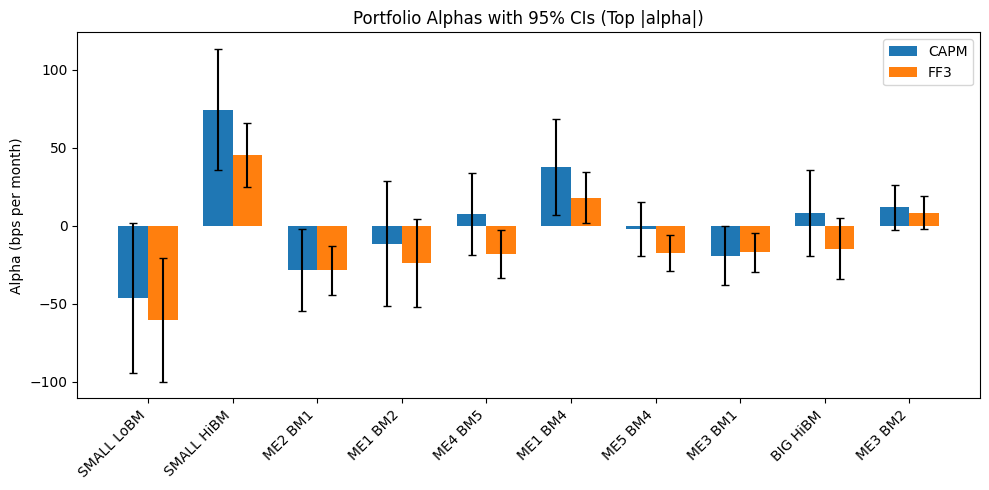

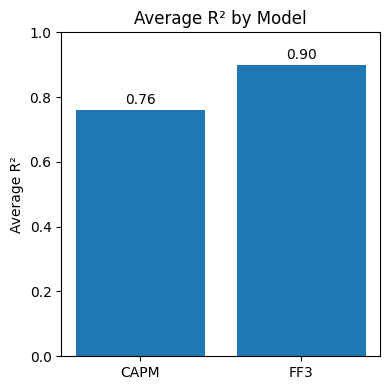

In [ ]:
# visuals for the ppt and report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============== Alpha bars with 95% CI (top |alpha|) ===============
# Collect what exists
models = []
if "capm_params" in globals() and isinstance(capm_params, pd.DataFrame):
    models.append(("CAPM", capm_params[["alpha","se_alpha"]].rename(columns={"alpha":"alpha","se_alpha":"se"})))
if "ff3_params" in globals() and isinstance(ff3_params, pd.DataFrame):
    models.append(("FF3", ff3_params[["alpha","se_alpha"]].rename(columns={"alpha":"alpha","se_alpha":"se"})))

# Build a table of alphas and SEs (in bps) across models
alpha_panel = []
for name, df in models:
    tmp = pd.DataFrame({
        "portfolio": df.index,
        f"alpha_{name}": (df["alpha"] * 10000.0),     # bps
        f"se_{name}":    (df["se"]    * 10000.0)      # bps
    }).set_index("portfolio")
    alpha_panel.append(tmp)

alpha_panel = pd.concat(alpha_panel, axis=1)

# Choose top 10 by |alpha| from the model that exists (prefer FF3 if both)
pick_from = "FF3" if "alpha_FF3" in alpha_panel else "CAPM"
topN = (
    alpha_panel[[f"alpha_{pick_from}"]]
    .assign(abs_val=lambda x: x[f"alpha_{pick_from}"].abs())
    .sort_values("abs_val", ascending=False)
    .head(10)
    .index
)
alpha_show = alpha_panel.loc[topN]

# Plot side-by-side bars for each model, with 95% CI error bars
labels = alpha_show.index.tolist()
x = np.arange(len(labels))
width = 0.35

fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

bar_offsets = []
if "alpha_CAPM" in alpha_show:
    bar1 = ax.bar(x - width/2, alpha_show["alpha_CAPM"].values, width,
                  yerr=1.96 * alpha_show["se_CAPM"].values, capsize=3, label="CAPM")
    bar_offsets.append("CAPM")
if "alpha_FF3" in alpha_show:
    bar2 = ax.bar(x + width/2, alpha_show["alpha_FF3"].values, width,
                  yerr=1.96 * alpha_show["se_FF3"].values, capsize=3, label="FF3")
    bar_offsets.append("FF3")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Alpha (bps per month)")
ax.set_title("Portfolio Alphas with 95% CIs (Top |alpha|)")
ax.legend()
plt.tight_layout()
plt.show()

# =============== Tiny Average R² bar chart ===============
avg_r2 = {}
if "capm_params" in globals() and "R2" in capm_params:
    avg_r2["CAPM"] = float(capm_params["R2"].mean())
if "ff3_params" in globals() and "R2" in ff3_params:
    avg_r2["FF3"] = float(ff3_params["R2"].mean())

if avg_r2:
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()
    ax.bar(list(avg_r2.keys()), list(avg_r2.values()))
    ax.set_ylim(0, 1)
    ax.set_ylabel("Average R²")
    ax.set_title("Average R² by Model")
    for i, k in enumerate(avg_r2.keys()):
        ax.text(i, avg_r2[k] + 0.02, f"{avg_r2[k]:.2f}", ha="center")
    plt.tight_layout()
    plt.show()
